# Notebook: TCN Model Training and Evaluation

In this notebook, we will load the stock data, preprocess it, build and train a TCN-based model (using our hybrid functions), and then evaluate and plot the results. All functions are imported from the `DL_TCN` module.

## 1. Importing Libraries and Module

First, we import the required libraries and the module containing our functions.


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.layers import Dropout
from tcn import TCN

In [155]:
def R2(y_true, y_pred):
    ss_res = tf.reduce_sum(
        tf.square(y_true - y_pred)
    )
    ss_tot = tf.reduce_sum(
        tf.square(y_true - tf.reduce_mean(y_true))
    )
    
    return 1 - ss_res / ss_tot


def ACCURACY_5(y_true, y_pred):
    # Erreur relative : |y_true - y_pred| / (|y_true| + epsilon) on evite les divisions par 0
    error = tf.abs(
        (y_true - y_pred) / (tf.abs(y_true))
    )
    correct = tf.cast(
        error <= 0.05,
        tf.float32
    )

    return tf.reduce_mean(correct)

def CREATE_SEQUENCES(values, sequence_length=60):
    X, y = [], []
    
    for i in range(sequence_length, len(values)):
        X_window = values[i - sequence_length: i]
        y_value = values[i] 
        X.append(X_window)
        y.append(y_value)
        
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    
    return X, y

def NN_MODEL(input_shape, learning_rate=0.0005):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        TCN(
            nb_filters=8,
            kernel_size=3,
            nb_stacks=1,
            dilations=[1, 2, 4, 8, 32],
            padding='causal',
            dropout_rate=0.2,
            return_sequences=False
        ),
        
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error', 
            R2, 
            ACCURACY_5
        ]
    )
    
    return model

## 2. Data Loading

We load our stock market data from a CSV file and extract the "close" price column.


In [156]:
# Load CSV data
df = pd.read_csv("/Users/welto/PycharmProjects/company_brandname/technical-and-fundamental-analysis-on-stock-markets/Datasets/NASDAQ_100.csv")

# Extract the 'close' column and reshape to (num_samples, 1)
close_prices = df['close'].values.reshape(-1, 1)

print("Data shape:", close_prices.shape)


Data shape: (9716, 1)


## 3. Data Preprocessing

Next, we normalize the close prices using a MinMaxScaler.


In [157]:
# Initialize and fit the scaler
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Check a few values
print("Scaled prices (first 5 rows):")
scaled_prices[:5]


Scaled prices (first 5 rows):


array([[-0.77483171],
       [-0.77496365],
       [-0.77496365],
       [-0.77496859],
       [-0.77459372]])

## 4. Creating Sequences

We use a sliding window approach to create input sequences and corresponding targets.
Here, we use a sequence length of 1000 days to predict the following day.


In [158]:
# Set sequence length (number of input days)
sequence_length = 2000

# Create sequences using the function from DL_TCN
X, y = CREATE_SEQUENCES(scaled_prices, sequence_length=sequence_length)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7716, 2000, 1)
y shape: (7716, 1)


## 5. Splitting the Dataset

We split the data into training (70%), validation (15%), and test (15%) sets.


In [159]:
# Determine split sizes
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# Create train, validation, and test splits
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (5401, 2000, 1) (5401, 1)
Validation shapes: (1157, 2000, 1) (1157, 1)
Test shapes: (1158, 2000, 1) (1158, 1)


## 6. Building the Model

We build our hybrid TCN+LSTM model using the function from the module.  
Our model takes sequences of shape (sequence_length, 1) and predicts a single value.


In [160]:
# Build the model using the function from DL_TCN
model = NN_MODEL(input_shape=(sequence_length, 1), learning_rate=0.0005)
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_15 (TCN)                    │ (None, 8)              │         1,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Training the Model

We train the model using EarlyStopping and ReduceLROnPlateau to avoid overfitting.


In [161]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)


Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy_5: 0.0116 - loss: 8.8591 - mean_absolute_error: 1.8500 - r2: -171.6324 - val_accuracy_5: 0.0051 - val_loss: 1.8223 - val_mean_absolute_error: 1.1082 - val_r2: -2855.7930 - learning_rate: 5.0000e-04
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy_5: 0.0359 - loss: 0.3977 - mean_absolute_error: 0.4162 - r2: -6.8271 - val_accuracy_5: 0.0025 - val_loss: 1.1177 - val_mean_absolute_error: 0.8768 - val_r2: -1808.4291 - learning_rate: 5.0000e-04
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy_5: 0.0347 - loss: 0.1998 - mean_absolute_error: 0.3073 - r2: -2.9098 - val_accuracy_5: 0.0059 - val_loss: 0.6862 - val_mean_absolute_error: 0.6961 - val_r2: -1167.1166 - learning_rate: 5.0000e-04
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy_5: 0.0531 - loss: 0.1267 - mean_absolute_error: 0.2444 - r2: -1.4199 - val_accuracy_5: 0.0059 - val_loss: 0.4564 - val_mean_absolute_error: 0.5703 -

## 8. Plotting the Training Loss

We now plot the training and validation loss curves (MSE) over epochs.


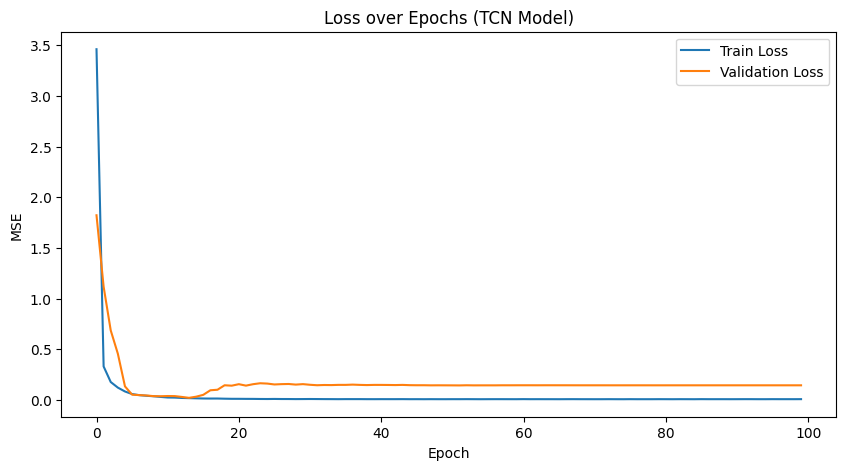

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Loss over Epochs (TCN Model)')
plt.legend()
plt.show()


## 9. Model Evaluation and Predictions

Next, we evaluate the model on the test set and predict closing prices.


In [163]:
# Evaluate on test set
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy_5: 0.0000e+00 - loss: 1.8047 - mean_absolute_error: 1.2325 - r2: -398.2206
Test Loss: [2.859853982925415, 1.6021071672439575, -534.2888793945312, 0.0]
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


## 10. Inverse Scaling and Metrics Calculation

We inverse the scaling to get the original closing price values, then calculate performance metrics (R², MAE, etc.).


In [164]:
# Inverse transform the predictions and true values
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

# Calculate metrics using functions from scikit-learn
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(np.mean((y_test_unscaled - y_pred_unscaled) ** 2))
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100
accuracy = ACCURACY_5(y_test_unscaled, y_pred_unscaled)

print("----- Test Set Performance -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Accuracy (5% tolerance): {accuracy:.2f}%")
print(f"MAPE: {mape:.2f}%")


----- Test Set Performance -----
RMSE: 6857.1765
MAE: 6496.2838
R²: -5.6074
Accuracy (5% tolerance): 0.00%
MAPE: 49.52%


## 11. Plotting Predictions vs. Real Values

Finally, we plot the predictions against the real closing prices for the first 100 test samples.


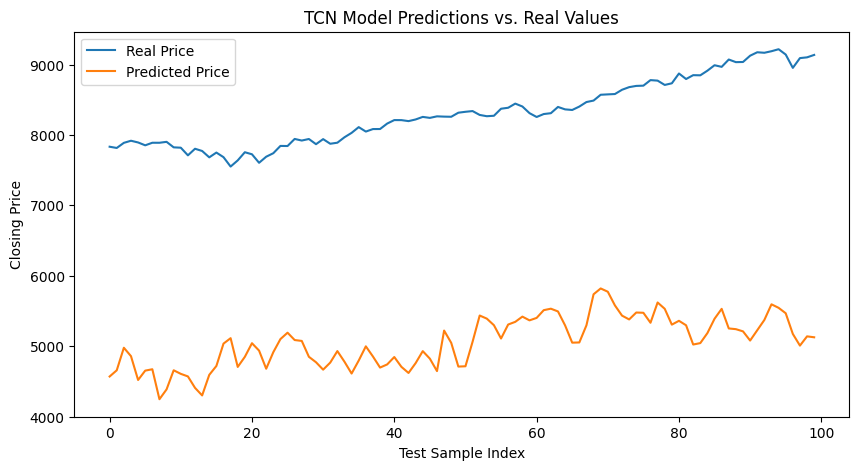

In [165]:
n_plot = 100
plt.figure(figsize=(10, 5))
plt.plot(y_test_unscaled[:n_plot], label='Real Price')
plt.plot(y_pred_unscaled[:n_plot], label='Predicted Price')
plt.xlabel("Test Sample Index")
plt.ylabel("Closing Price")
plt.title("TCN Model Predictions vs. Real Values")
plt.legend()
plt.show()
